In [14]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import arabic_reshaper
from bidi.algorithm import get_display

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [3]:
# Load your data (adjust the path and column names as per your dataset)
# Assuming the data file is in CSV format with 'sentence' and 'category' columns
data = pd.read_csv('Final_collected_data/merged_dhia.csv', sep=',', encoding='utf-8')

# Filter out categories with less than 2 occurrences
category_counts = data['Category'].value_counts()
filtered_data = data[data['Category'].isin(category_counts[category_counts >= 10].index)]

# Update X and y with the filtered data
sentences = filtered_data['processed_quotes']
labels = filtered_data['Category']

# Display the value counts of the filtered categories
filtered_data['Category'].value_counts()

Category
الصبر                   905
الرحمة                  746
الشجاعة                 637
التودد                  616
التغافل                 576
                       ... 
النصح                    14
الخبرة في الحياة         12
الصداقة                  11
المدح ومكارم الأخلاق     11
الجد والعمل              10
Name: count, Length: 121, dtype: int64

In [4]:
# Encode labels to numeric values
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(sentences, labels, test_size=0.2, random_state=42, stratify=labels)

In [5]:
# Tokenize the sentences
max_words = 100
max_len = 100

In [6]:
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)

# Convert text to sequences of integers
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad sequences to ensure equal length
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

In [6]:
# Build the LSTM model
model = Sequential()

# Embedding layer
model.add(Embedding(input_dim=max_words, output_dim=100, input_length=max_len))

# LSTM layer
model.add(LSTM(128, return_sequences=False))

# Dropout to avoid overfitting
model.add(Dropout(0.5))

# Dense layer for classification
model.add(Dense(64, activation='relu'))
model.add(Dense(len(label_encoder.classes_), activation='softmax'))  # Number of categories

In [7]:
# Compile the model
model.compile(loss='sparse_categorical_crossentropy', 
              optimizer=Adam(), 
              metrics=['accuracy'])

In [8]:
# Train the model
model.fit(X_train_pad, y_train, epochs=10, batch_size=32, validation_data=(X_test_pad, y_test))

Epoch 1/10
584/584 [==============================] - 38s 62ms/step - loss: 3.8500 - accuracy: 0.1974 - val_loss: 2.9429 - val_accuracy: 0.4113
Epoch 2/10
584/584 [==============================] - 41s 69ms/step - loss: 2.8186 - accuracy: 0.4289 - val_loss: 2.6822 - val_accuracy: 0.4436
Epoch 3/10
584/584 [==============================] - 39s 67ms/step - loss: 2.6195 - accuracy: 0.4506 - val_loss: 2.5911 - val_accuracy: 0.4599
Epoch 4/10
584/584 [==============================] - 42s 72ms/step - loss: 2.5284 - accuracy: 0.4635 - val_loss: 2.5182 - val_accuracy: 0.4653
Epoch 5/10
584/584 [==============================] - 46s 78ms/step - loss: 2.4523 - accuracy: 0.4718 - val_loss: 2.4864 - val_accuracy: 0.4676
Epoch 6/10
584/584 [==============================] - 57s 98ms/step - loss: 2.4081 - accuracy: 0.4756 - val_loss: 2.4591 - val_accuracy: 0.4726
Epoch 7/10
584/584 [==============================] - 57s 98ms/step - loss: 2.3641 - accuracy: 0.4805 - val_loss: 2.4412 - val_accuracy:

In [42]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test_pad, y_test)
print(f'Test Accuracy: {test_acc:.4f}')
print(f'Test Loss: {test_loss:.4f}')

146/146 [==============================] - 4s 23ms/step - loss: 2.3938 - accuracy: 0.4820
Test Accuracy: 0.4820
Test Loss: 2.3938


In [45]:
# Load the new dataset
test_data = pd.read_csv('test_2.csv', sep=',', encoding='utf-8')

# Preprocess the new dataset
test_sentences = test_data['processed_quotes']
test_labels = test_data['Category']
test_labels = label_encoder.transform(test_labels)

# Convert text to sequences of integers
test_seq = tokenizer.texts_to_sequences(test_sentences)

# Pad sequences to ensure equal length
test_pad = pad_sequences(test_seq, maxlen=max_len)

# Evaluate the model on the new dataset
test_loss, test_acc = model.evaluate(test_pad, test_labels)
print(f'Test Accuracy: {test_acc:.4f}')
print(f'Test Loss: {test_loss:.4f}')

5/5 [==============================] - 0s 26ms/step - loss: 5.1246 - accuracy: 0.2123
Test Accuracy: 0.2123
Test Loss: 5.1246


In [12]:
model.save("LSTM.h5")

In [11]:
from tensorflow.keras.models import load_model

# Load the model from the file
model = load_model('LSTM.h5')

In [30]:
y_pred = model.predict(X_test_pad)

146/146 [==============================] - 3s 24ms/step


In [31]:
conf_matrix = confusion_matrix(y_test, np.argmax(y_pred, axis=1))

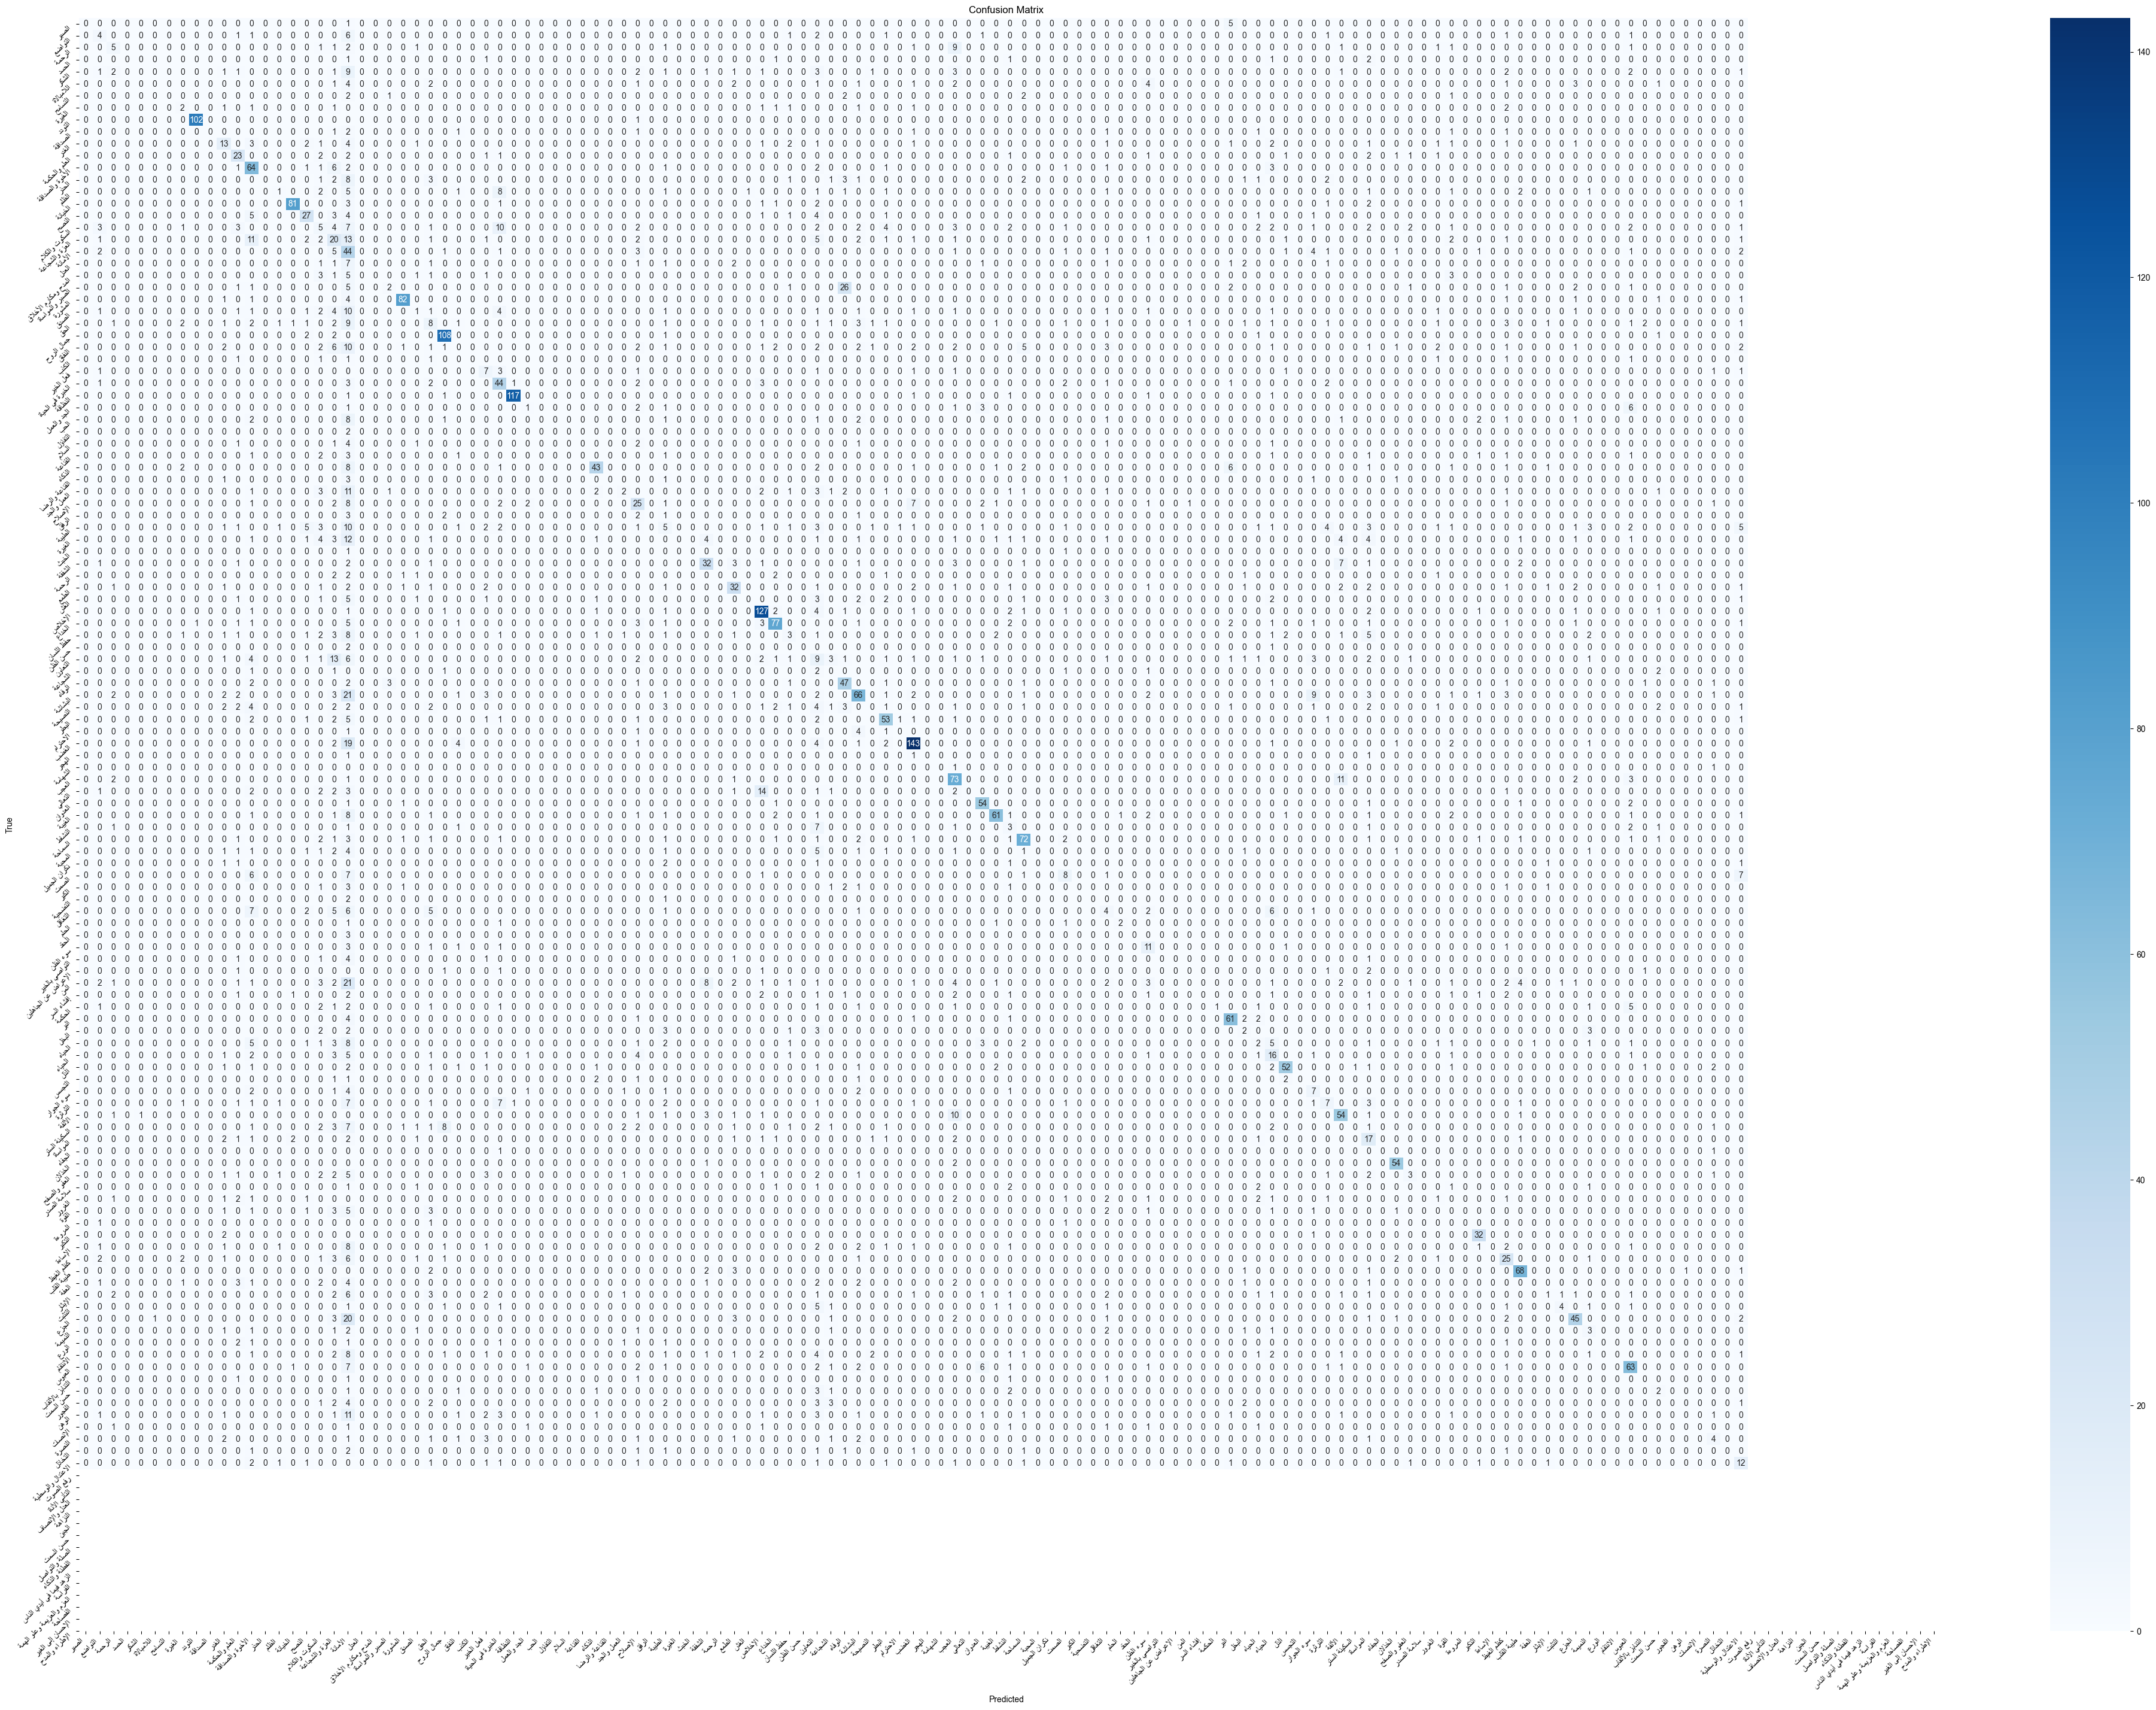

In [32]:
plt.rcParams['font.family'] = 'Arial'  # Set the font to DejaVu Sans

plt.figure(figsize=(50, 35))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=[get_display(arabic_reshaper.reshape(label)) for label in data['Category'].unique()], 
            yticklabels=[get_display(arabic_reshaper.reshape(label)) for label in data['Category'].unique()])

# Set Arabic font for the labels
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=45, va='top')

plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [41]:
# Alternative: Display the classification report as a DataFrame for better readability
# Generate the classification report
report = classification_report(y_test, np.argmax(y_pred, axis=1), target_names=label_encoder.classes_, output_dict=True)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
report_df = pd.DataFrame(report).transpose()
print("Classification Report:")
print(report_df)

Classification Report:
                           precision    recall  f1-score      support
 الغيرة                     0.000000  0.000000  0.000000     6.000000
إفشاء السر                  0.160000  0.200000  0.177778    20.000000
الأخوة والصداقة             0.250000  0.200000  0.222222    25.000000
الألفة                      0.000000  0.000000  0.000000     7.000000
الأمانة                     0.000000  0.000000  0.000000    34.000000
الإخلاص                     0.000000  0.000000  0.000000    24.000000
الإساءة                     0.000000  0.000000  0.000000     8.000000
الإصلاح                     0.166667  0.166667  0.166667    12.000000
الإعراض عن الجاهلين         0.990291  0.990291  0.990291   103.000000
الإنصات                     0.000000  0.000000  0.000000    10.000000
الإيثار                     0.288889  0.342105  0.313253    38.000000
الاحترام                    0.383333  0.621622  0.474227    37.000000
الاعتدال والوسطية           0.423841  0.761905  0.544681    84.0000

d:\Dhia\ING INFO 2\Semestre 1\Projet traitement de données\Project\data collection\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Dhia\ING INFO 2\Semestre 1\Projet traitement de données\Project\data collection\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Dhia\ING INFO 2\Semestre 1\Projet traitement de données\Project\data collection\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with

In [9]:
# Function to preprocess and predict the category of a new sentence
def predict_category(sentence, model, tokenizer, label_encoder, max_len=100):
    # Step 1: Tokenize the sentence
    sentence_seq = tokenizer.texts_to_sequences([sentence])
    
    # Step 2: Pad the sequence to match the input length used during training
    sentence_pad = pad_sequences(sentence_seq, maxlen=max_len)
    
    # Step 3: Predict the category (the model will return probabilities for each class)
    prediction = model.predict(sentence_pad)
    
    # Step 4: Get the index of the class with the highest probability
    predicted_class_idx = np.argmax(prediction, axis=-1)[0]
    
    # Step 5: Decode the index back to the original label
    predicted_class = label_encoder.inverse_transform([predicted_class_idx])[0]
    
    return predicted_class

In [12]:
# Example usage:
new_sentence = "الذين يواجهون الرياح العاتية دون أن يلينوا، هم من يصنعون الطرق التي يسلكها الآخرون."

predicted_category = predict_category(new_sentence, model, tokenizer, label_encoder)

print(f"Predicted Category: {predicted_category}")


1/1 [==============================] - 1s 771ms/step
Predicted Category: التثبت
